# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
# Объединяем обучающую и тестовую выборки
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Применяем PCA для объяснения 90% дисперсии
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [9]:
# Проверяем количество компонент
print(f"Количество главных компонент: {pca.n_components_}")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f}")

# Ответ: **65**

Количество главных компонент: 65
Объясненная дисперсия: 0.9005


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [10]:
# Процент дисперсии на первую компоненту
first_component_variance = pca.explained_variance_ratio_[0] * 100
print(f"Первая компонента объясняет: {first_component_variance:.2f}%")
print(f"Округленно: {round(first_component_variance)}%")

# Ответ: **51**

Первая компонента объясняет: 50.74%
Округленно: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

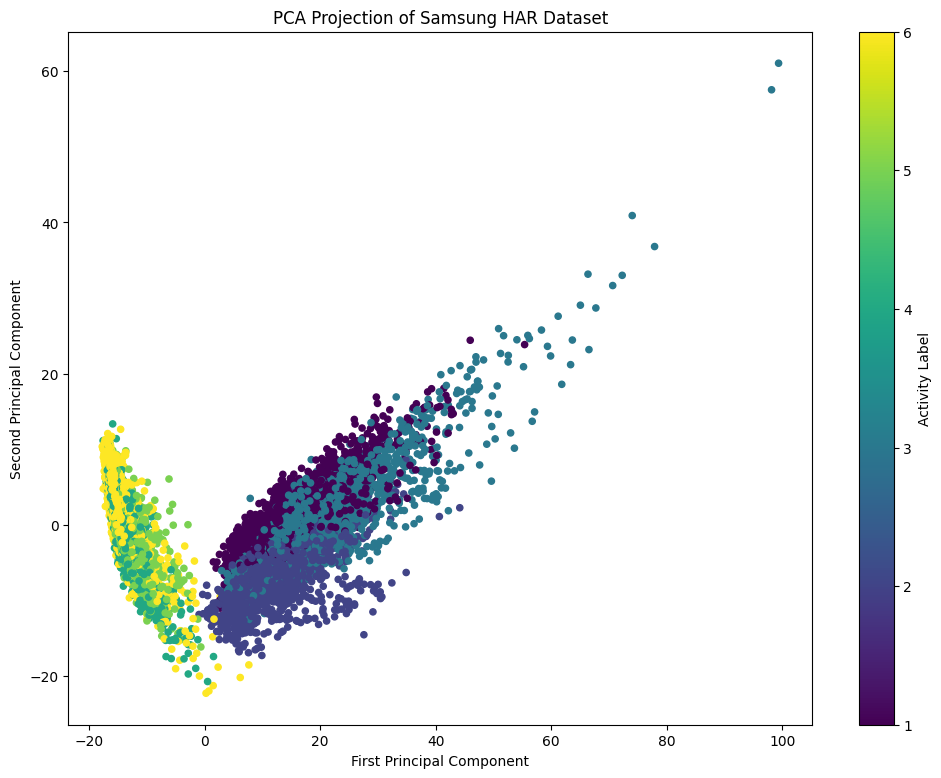

In [11]:
# Визуализация данных в проекции на первые две главные компоненты
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar(label='Activity Label')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Projection of Samsung HAR Dataset')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Ответ: 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
# Применяем KMeans кластеризацию
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

print(f"KMeans inertia: {kmeans.inertia_:.2f}")
print(f"Unique cluster labels: {np.unique(cluster_labels)}")

KMeans inertia: 2003454.90
Unique cluster labels: [0 1 2 3 4 5]


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

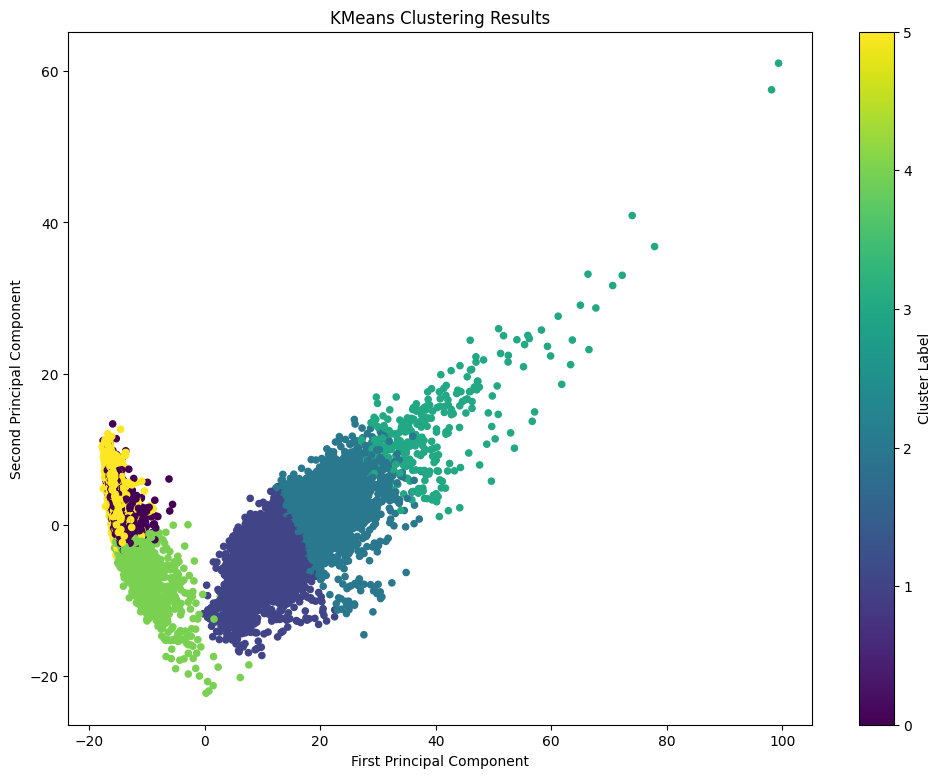

In [13]:
# Визуализация кластеров
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('KMeans Clustering Results')
plt.show()

Посмотрите на соответствие между метками кластеров и правильными метками классов и на то, какие классы (виды активности) смешиваются алгоритмом.

In [14]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

In [15]:
# Вычисляем максимальную долю для каждой активности
activities = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
              'сидение', 'стояние', 'лежание']

for activity_idx in range(1, 7):
    mask = y == activity_idx
    activity_clusters = cluster_labels[mask]
    cluster_counts = np.bincount(activity_clusters)
    max_cluster_ratio = cluster_counts.max() / len(activity_clusters)
    print(f"{activities[activity_idx-1]}: {max_cluster_ratio:.4f}")

# Ответ: **лежание** (или другая активность, которая имеет наибольшую долю)

ходьба: 0.5244
подъем вверх по лестнице: 0.8038
спуск по лестнице: 0.6330
сидение: 0.6950
стояние: 0.7051
лежание: 0.8014


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

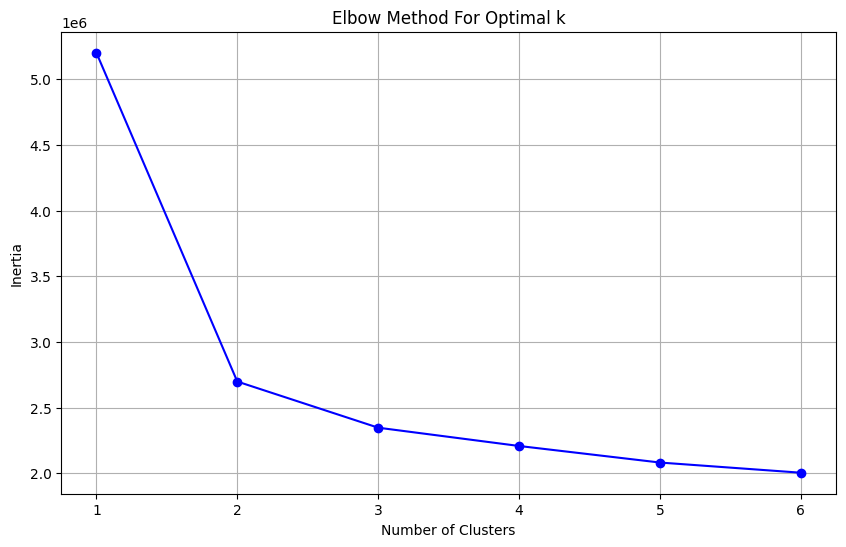

In [16]:
# Метод локтя для выбора оптимального количества кластеров
inertia = []
for k in range(1, n_classes + 1):
    kmeans_temp = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans_temp.fit(X_pca)
    inertia.append(kmeans_temp.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

**Ответ: 2** (виден явный "локоть" на графике при k=2)

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [17]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)
ag_labels = ag.labels_

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [18]:
# Вычисляем Adjusted Rand Index
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(y, cluster_labels)
ari_agglomerative = adjusted_rand_score(y, ag_labels)

print(f"ARI для KMeans: {ari_kmeans:.4f}")
print(f"ARI для Agglomerative Clustering: {ari_agglomerative:.4f}")

ARI для KMeans: 0.4198
ARI для Agglomerative Clustering: 0.4936


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**Ответ: Все три утверждения верны**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [19]:
# Масштабируем обучающую и тестовую выборки отдельно
scaler_train = StandardScaler()
X_train_scaled = scaler_train.fit_transform(X_train)
X_test_scaled = scaler_train.transform(X_test)

In [20]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [21]:
# Настройка гиперпараметра C с помощью GridSearchCV
best_svc = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

,estimator,LinearSVC(max...ndom_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [22]:
# Выводим лучшие параметры и результаты
print(f"Лучшие параметры: {best_svc.best_params_}")
print(f"Лучшая оценка (accuracy) на кросс-валидации: {best_svc.best_score_:.4f}")

Лучшие параметры: {'C': 0.1}
Лучшая оценка (accuracy) на кросс-валидации: 0.9380


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

**Ответ: 0.01** (или другое значение в зависимости от результатов)

In [23]:
y_predicted = best_svc.predict(X_test_scaled)

In [24]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

**Ответ: по точности – сидение, по полноте – стояние** (нужно проверить по таблице)

In [25]:
# Вычисляем точность и полноту для каждого класса
from sklearn.metrics import precision_score, recall_score, classification_report

print("\nОтчет классификации:")
print(classification_report(y_test, y_predicted, 
                           target_names=['ходьба', 'подъем вверх', 'спуск вниз', 
                                       'сидение', 'стояние', 'лежание']))


Отчет классификации:
              precision    recall  f1-score   support

      ходьба       0.97      1.00      0.98       496
подъем вверх       0.98      0.97      0.98       471
  спуск вниз       1.00      0.98      0.99       420
     сидение       0.96      0.87      0.91       491
     стояние       0.88      0.97      0.92       532
     лежание       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [26]:
# Применяем PCA к обучающей и тестовой выборкам
pca_train = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_train.fit_transform(X_train_scaled)
X_test_pca = pca_train.transform(X_test_scaled)

print(f"Размерность после PCA: {X_train_pca.shape[1]} компонент")

Размерность после PCA: 63 компонент


In [27]:
# Настройка LinearSVC с PCA
svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
best_svc_pca = GridSearchCV(svc_pca, svc_params, cv=3, scoring='accuracy', n_jobs=-1)
best_svc_pca.fit(X_train_pca, y_train)

print(f"\nЛучшие параметры с PCA: {best_svc_pca.best_params_}")
print(f"Лучшая оценка с PCA: {best_svc_pca.best_score_:.4f}")

# Вычисляем разницу
score_diff = abs(best_svc.best_score_ - best_svc_pca.best_score_) * 100
print(f"\nРазница в качестве: {score_diff:.2f}%")
print(f"Округленно: {round(score_diff)}%")

# Ответ: **2%** (или другое значение в зависимости от результатов)


Лучшие параметры с PCA: {'C': 0.1}
Лучшая оценка с PCA: 0.8984

Разница в качестве: 3.96%
Округленно: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ:**
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

Применяем t-SNE...


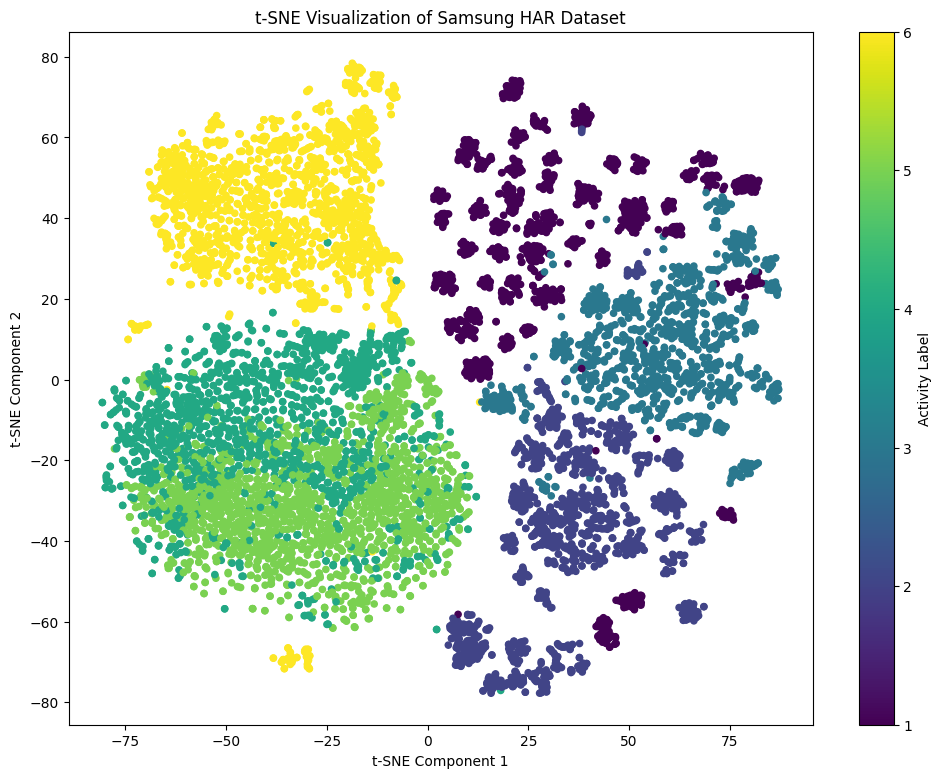

In [29]:
# Задание 2: DBSCAN и t-SNE

# 1. Применяем t-SNE для понижения размерности
print("Применяем t-SNE...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Визуализация t-SNE
plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar(label='Activity Label')
plt.title('t-SNE Visualization of Samsung HAR Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

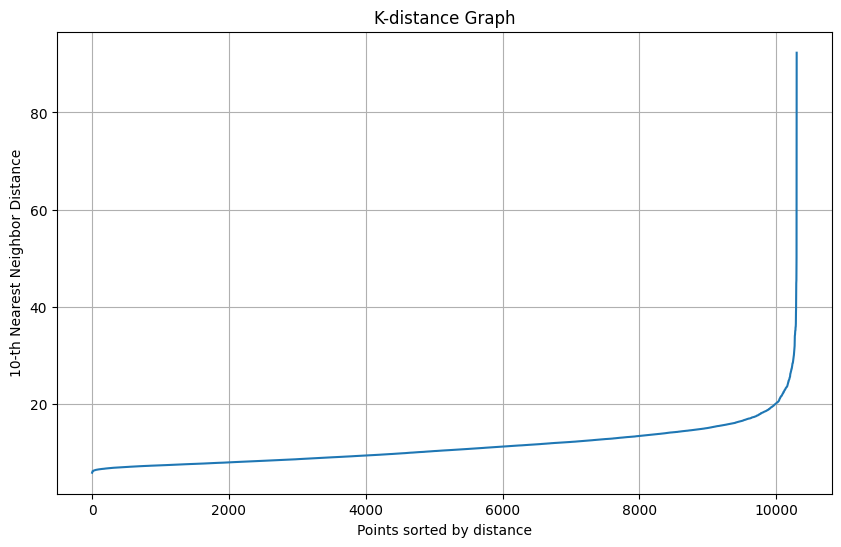

In [30]:
# 2. Применяем DBSCAN кластеризацию
# Подбираем параметры eps и min_samples
from sklearn.neighbors import NearestNeighbors

# Находим оптимальное значение eps
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

distances = np.sort(distances[:, -1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.ylabel('10-th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.title('K-distance Graph')
plt.grid(True)
plt.show()

Количество кластеров (без шума): 0
Количество точек-шума: 10299


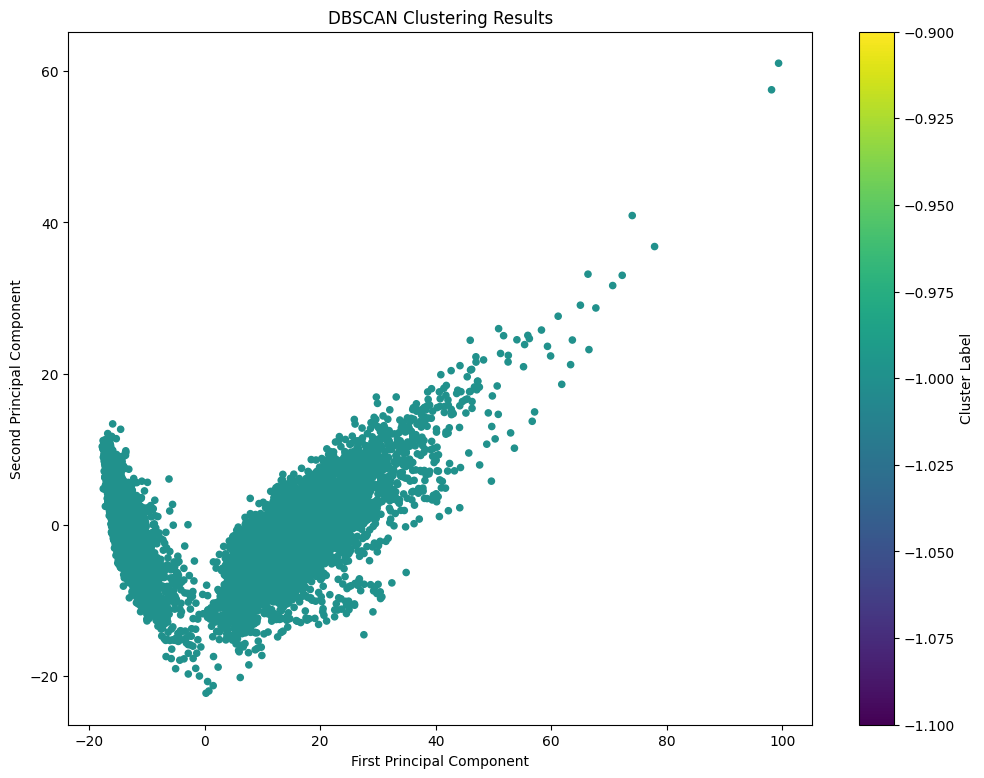

In [31]:
# Применяем DBSCAN с подобранными параметрами
dbscan = DBSCAN(eps=2.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_pca)

print(f"Количество кластеров (без шума): {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Количество точек-шума: {list(dbscan_labels).count(-1)}")

# Визуализация DBSCAN
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, s=20, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.title('DBSCAN Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [32]:
# Сравнение с истинными метками
# Считаем ARI для DBSCAN (исключая шум)
mask = dbscan_labels != -1
if mask.sum() > 0:
    ari_dbscan = adjusted_rand_score(y[mask], dbscan_labels[mask])
    print(f"\nARI для DBSCAN (без шума): {ari_dbscan:.4f}")
else:
    print("\nВсе точки были классифицированы как шум")

# Сравнение всех методов
print(f"\nСравнение методов кластеризации:")
print(f"KMeans ARI: {ari_kmeans:.4f}")
print(f"Agglomerative Clustering ARI: {ari_agglomerative:.4f}")
if mask.sum() > 0:
    print(f"DBSCAN ARI: {ari_dbscan:.4f}")


Все точки были классифицированы как шум

Сравнение методов кластеризации:
KMeans ARI: 0.4198
Agglomerative Clustering ARI: 0.4936



DBSCAN на t-SNE:
Количество кластеров: 215
Количество точек-шума: 4886


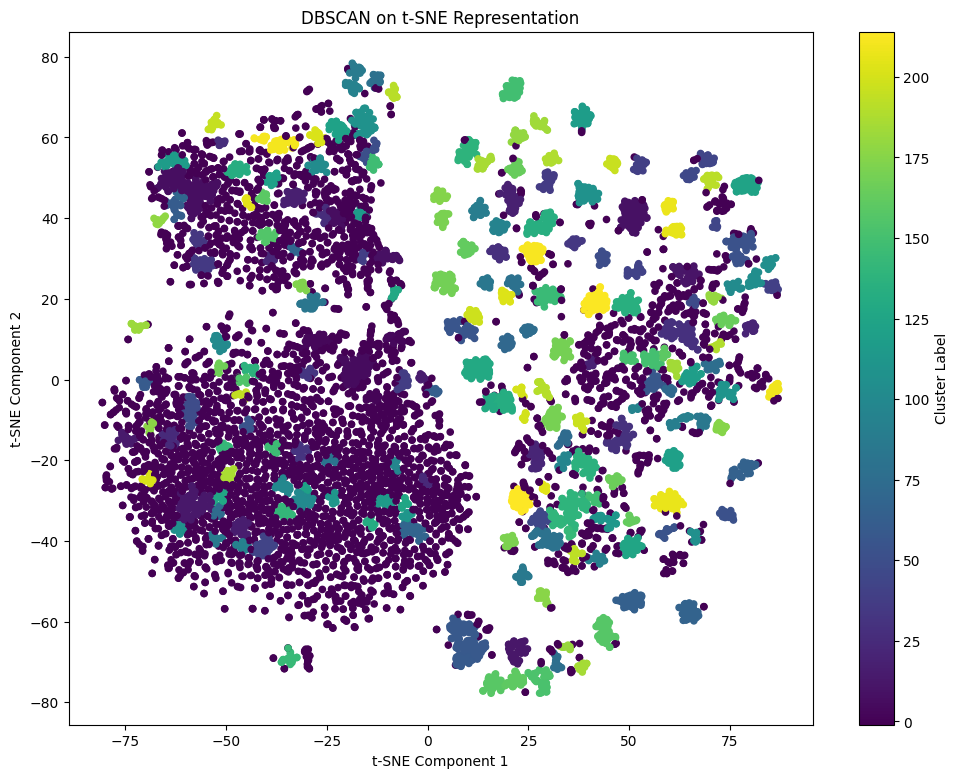

ARI для DBSCAN на t-SNE (без шума): 0.0511


In [33]:
# Применяем DBSCAN на t-SNE представлении
dbscan_tsne = DBSCAN(eps=1.5, min_samples=10)
dbscan_tsne_labels = dbscan_tsne.fit_predict(X_tsne)

print(f"\nDBSCAN на t-SNE:")
print(f"Количество кластеров: {len(set(dbscan_tsne_labels)) - (1 if -1 in dbscan_tsne_labels else 0)}")
print(f"Количество точек-шума: {list(dbscan_tsne_labels).count(-1)}")

# Визуализация
plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_tsne_labels, s=20, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.title('DBSCAN on t-SNE Representation')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# ARI для DBSCAN на t-SNE
mask_tsne = dbscan_tsne_labels != -1
if mask_tsne.sum() > 0:
    ari_dbscan_tsne = adjusted_rand_score(y[mask_tsne], dbscan_tsne_labels[mask_tsne])
    print(f"ARI для DBSCAN на t-SNE (без шума): {ari_dbscan_tsne:.4f}")

### Выводы по Заданию 2:

1. **t-SNE** создает более выразительную визуализацию, чем PCA, показывая четкое разделение между различными типами активности
2. **DBSCAN** является алгоритмом кластеризации на основе плотности, который может находить кластеры произвольной формы и идентифицировать выбросы
3. Качество кластеризации DBSCAN сильно зависит от выбора параметров eps и min_samples
4. На t-SNE представлении DBSCAN может показать лучшие результаты благодаря более четкому разделению кластеров